# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [3]:
from sklearn.datasets import make_circles, make_moons, load_breast_cancer, make_regression, load_diabetes, make_blobs
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Code

In [4]:
class Booster:
    
    def __init__(self, learning_rate: int, n_estimators: int):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        
    def _fit_first_estimator(self, X, y):
        raise NotImplementedError
    
    def fit(self, X, y):
        raise NotImplementedError
    
    def predict(self, X):
        raise NotImplementedError

In [5]:
class BoostingRegressor(Booster):
    
    def __init__(self, max_depth: int, **kwargs):
        super().__init__(**kwargs)
        self.first_estimator = None
        self.max_depth = max_depth
    
    def _fit_first_estimator(self, X, y):
        self.first_estimator = LinearRegression()
        self.first_estimator.fit(X, y)
    
    def _fit_base_estimator(self, X, y):
        model = DecisionTreeRegressor(max_depth=self.max_depth)
        model.fit(X, y)
        return model
        
    def fit(self, X, y):
        self._fit_first_estimator(X, y)
        
        for i in range(1, self.n_estimators):
            y_pred = self.first_estimator.predict(X)
            for estimator in self.estimators:
                y_pred += self.learning_rate * estimator.predict(X)
            model = self._fit_base_estimator(X, self.derivate_loss(y, y_pred))
            self.estimators.append(model)
            
    
    def derivate_loss(self, y_true, y_pred):
        'MSE loss derivate'
        return y_true - y_pred
    
    def predict(self, X):
        y_pred = self.first_estimator.predict(X)
        for estimator in self.estimators:
            y_pred += self.learning_rate * estimator.predict(X)
        return y_pred

In [6]:
class BoostingClassifier(Booster):
    """
    Binary classifier
    """
    
    def __init__(self, max_depth: int, random_state: int = 0, **kwargs):
        super().__init__(**kwargs)
        self.first_estimator = None
        self.max_depth = max_depth
        self.random_state = random_state
        
    def __str__(self):
        return "BoostingClassifier"
    
    def _fit_first_estimator(self, X, y):
        self.first_estimator = LinearRegression()
        self.first_estimator.fit(X, y)
    
    def _fit_base_estimator(self, X, y):
        model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
        model.fit(X, y)
        return model
        
    def fit(self, X, y):
        self._fit_first_estimator(X, y)
        
        for i in range(1, self.n_estimators):
            y_pred = self.first_estimator.predict(X)
            for estimator in self.estimators:
                y_pred += self.learning_rate * (estimator.predict(X))
            model = self._fit_base_estimator(X, self.derivate_loss(y, y_pred))
            self.estimators.append(model)
            
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivate_loss(self, y_true, y_pred):
        'Log loss derivate'
        return y_true - self._sigmoid(y_pred)
    
    def predict_proba(self, X):
        y_pred = self.first_estimator.predict(X)
        for estimator in self.estimators:
            y_pred += self.learning_rate * (estimator.predict(X))
        return self._sigmoid(y_pred)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return np.round(preds)

In [7]:
class BoostingMultiClassifier(Booster):
    """
    Binary multi-classifier
    """
    
    def __init__(self, max_depth: int, random_state: int = 0, **kwargs):
        super().__init__(**kwargs)
        self.first_estimator = None
        self.max_depth = max_depth
        self.random_state = random_state
        
    def __str__(self):
        return "BoostingMultiClassifier"
    
    def _fit_first_estimator(self, X, y):
        self.first_estimator = LinearRegression()
        self.first_estimator.fit(X, y)
    
    def _fit_base_estimator(self, X, y):
        model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
        model.fit(X, y)
        return model
        
    def fit(self, X, y):
        
        n_class = np.unique(y).shape[0]
        y_hot = self._one_hot(y, n_class)
        
        self._fit_first_estimator(X, y_hot)
        
        for i in range(1, self.n_estimators):
            y_pred = self.first_estimator.predict(X)
            for estimator in self.estimators:
                y_pred += self.learning_rate * (estimator.predict(X))
            model = self._fit_base_estimator(X, self.derivate_loss(y_hot, y_pred))
            self.estimators.append(model)
            
    def _one_hot(self, y, c):
        y_hot = np.zeros((len(y), c))
        y_hot[np.arange(len(y)), y] = 1
        return y_hot
    
    def _softmax(self, z):
        exp = np.exp(z - np.max(z))
        for i in range(len(z)):
            exp[i] /= np.sum(exp[i])
        return exp
    
    def derivate_loss(self, y_true, y_pred):
        'Log loss derivate'
        return y_true - self._softmax(y_pred)
    
    def predict_proba(self, X):
        y_pred = self.first_estimator.predict(X)
        for estimator in self.estimators:
            y_pred += self.learning_rate * (estimator.predict(X))
        return self._softmax(y_pred)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return np.argmax(preds, axis=1)

## Helpers

In [8]:
def plot_mesh_grid(clf_list, X, y):
    i = 1
    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    for clf in clf_list:
        plt.subplot(1, 3, i)
    
        eps = 0.3

        xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 100),
                             np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 100))
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()][:, :]).reshape(xx.shape)

        plt.pcolormesh(xx, yy, z, cmap='Spectral', shading='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral', edgecolors='black')
        plt.title(clf)
        
        i+=1

In [9]:
def fit_ensemble(X, y, task):
    
    if task == 'clf':
    
        my_grad_2 = BoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

        my_grad_m = BoostingMultiClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

        sk_grad = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
        
        my_grad_2.fit(X, y)
        my_grad_m.fit(X, y)
        sk_grad.fit(X, y)
    
        return my_grad_2, my_grad_m, sk_grad
        
    else:
        
        my_grad = BoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)

        sk_grad = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
        
        my_grad.fit(X, y)
        sk_grad.fit(X, y)
    
        return my_grad, sk_grad

In [10]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(10, 8)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

## Classification

### Moons

In [11]:
X, y = make_moons(300, noise=0.2, random_state=42)

In [12]:
my_grad_2, my_grad_m, sk_grad = fit_ensemble(X, y, 'clf')

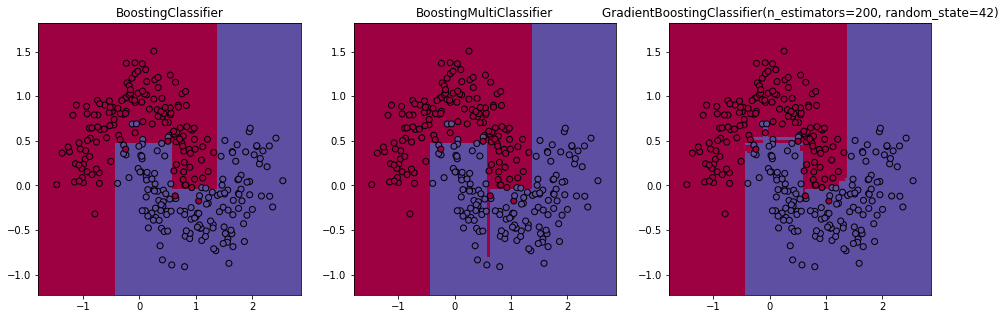

In [13]:
plot_mesh_grid([my_grad_2, my_grad_m, sk_grad], X, y)

### Circles

In [14]:
X, y = make_circles(300, noise=0.2, random_state=42, factor=0.2)

In [15]:
my_grad_2, my_grad_m, sk_grad = fit_ensemble(X, y, 'clf')

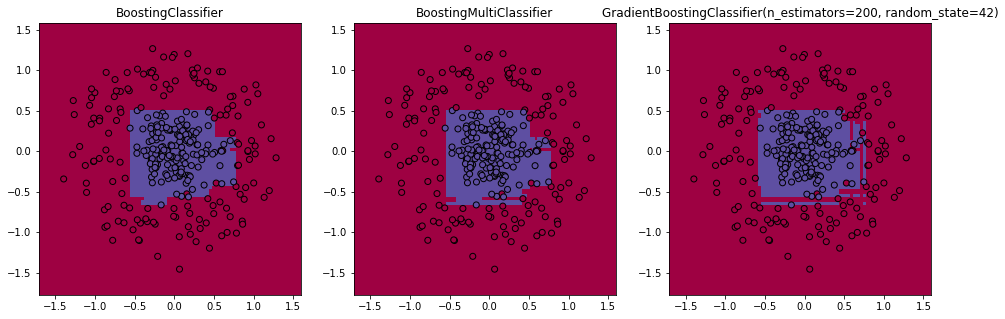

In [16]:
plot_mesh_grid([my_grad_2, my_grad_m, sk_grad], X, y)

### Breast cancer

In [17]:
X, y = load_breast_cancer().data, load_breast_cancer().target

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
my_grad_2, my_grad_m, sk_grad = fit_ensemble(X_train, y_train, 'clf')

In [19]:
print(classification_report(y_test, my_grad_2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [20]:
print(classification_report(y_test, my_grad_m.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        63
           1       0.98      0.96      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171



In [21]:
print(classification_report(y_test, sk_grad.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        63
           1       0.96      0.96      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



### MultiClass

In [22]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

Accuracy = 0.9766666666666667


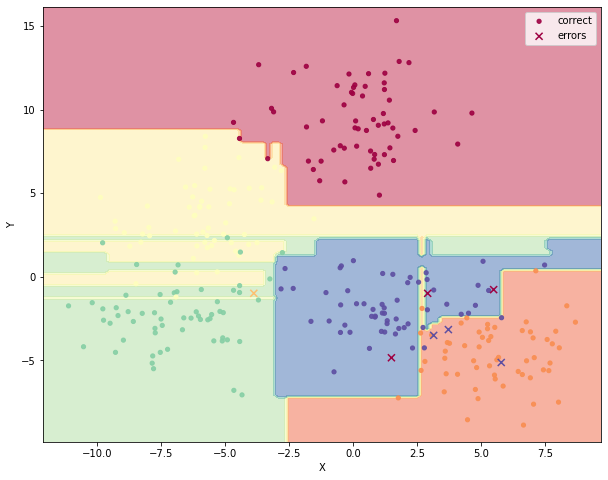

In [23]:
my_grad_m = BoostingMultiClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
my_grad_m.fit(X, y)
plot_decision_surface(my_grad_m, X, y)

Accuracy = 1.0


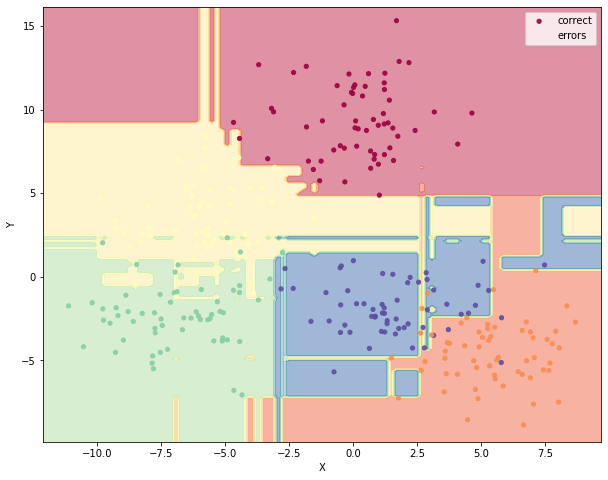

In [24]:
sk_grad = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
sk_grad.fit(X, y)
plot_decision_surface(sk_grad, X, y)

## Regression

### sin

In [25]:
def F(x):
    return 3*np.sin(x*2)

In [26]:
X = np.linspace(-3,3)
y = F(X) + np.random.randn(len(X))
X = X.reshape(-1,1)

In [27]:
my_grad, sk_grad = fit_ensemble(X, y, 'reg')

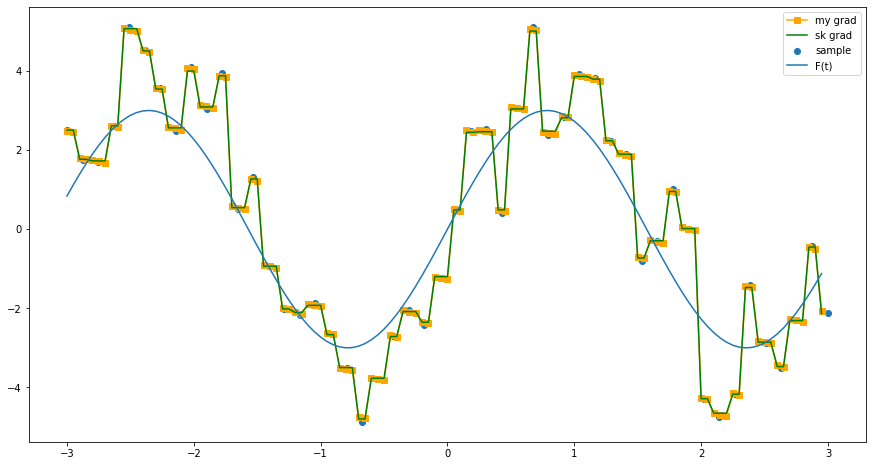

In [28]:
plt.figure(figsize=(15,8))
t = np.arange(-3, 3, 0.05).reshape(-1,1)
pred_my = my_grad.predict(t)
pred_sk = sk_grad.predict(t)
plt.plot(t, pred_my, color='orange', label='my grad', marker='s')
plt.plot(t, pred_sk, color='green', label='sk grad')
plt.scatter(X, y, label='sample')
plt.plot(t, F(t), label='F(t)')
plt.legend()

### diabets

In [29]:
X, y = load_diabetes().data, load_diabetes().target

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
my_grad, sk_grad = fit_ensemble(X_train, y_train, 'reg')

In [31]:
mean_squared_error(y_test, my_grad.predict(X_test))

3552.490960833219

In [32]:
mean_squared_error(y_test, sk_grad.predict(X_test))

3301.7996053088254

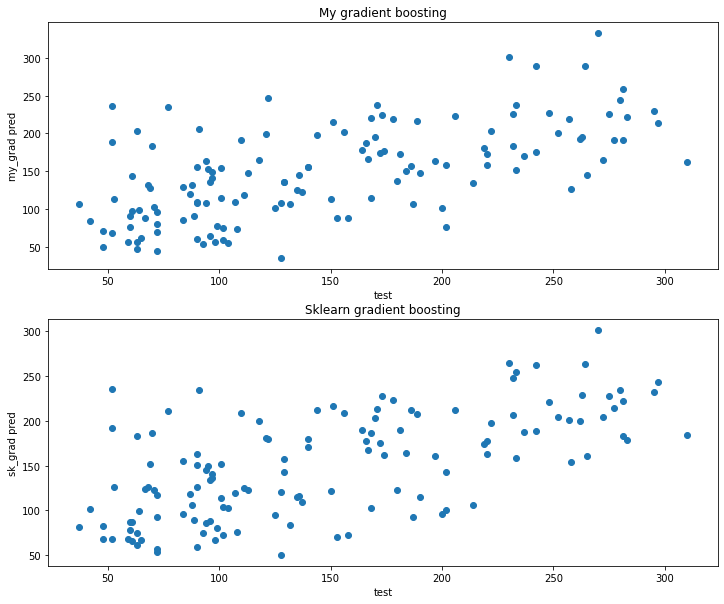

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))

plt.subplot(2, 1, 1)
plt.title('My gradient boosting')
plt.scatter(y_test, my_grad.predict(X_test))
plt.xlabel('test')
plt.ylabel('my_grad pred')

plt.subplot(2, 1, 2)
plt.title('Sklearn gradient boosting')
plt.scatter(y_test, sk_grad.predict(X_test))
plt.xlabel('test')
plt.ylabel('sk_grad pred')

plt.show()